<img src="https://drive.google.com/uc?export=view&id=1y4sp2N4jV4F18EYHzGV5VxrOqRF7f1y1" style="width:100%;height:auto">


In [ ]:
!pip install clearml
!clearml-init

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.1 MB/s eta 0:00:00
ClearML SDK setup process

Please create new clearml credentials through the settings page in your `clearml-server` web app (e.g. http://localhost:8080//settings/workspace-configuration) 
Or create a free account at https://app.clear.ml/settings/workspace-configuration

In settings page, press "Create new credentials", then press "Copy to clipboard".

Paste copied configuration here:
api {   # Kamyll Bell's workspace   web_server: https://app.clear.ml/   api_server: https://api.clear.ml   files_server: https://files.clear.ml   credentials {     "access_key" = "424CLPMJPB4GHGDAIFJMCE9QU8SY8D"     "secret_key" = "NkW0NjW7AokQEDhLj3hjlQAf7XaKb60URORw08ap2cOBL_FAoMeeG-1QSKUtX6du_4M"   } }
Detected credentials key="424CLPMJPB4GHGDAIFJMCE9QU8SY8D" secret="NkW0***"

ClearML Hosts configuration:
Web App: https://app.clear.ml/
API: https://api.clear.ml
File Store: https://files.clear.ml

Verifying credentials ...
Crede

# **Configuraciones**

In [ ]:
#@title **Montar Drive y definir rutas**
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title **Importar librerías**
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import math

from PIL import Image
import datetime
import random
import gc

from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import ResNet50, DenseNet201, EfficientNetB0, Xception
from tensorflow.keras import layers, models, optimizers, regularizers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import densenet, resnet50, xception

from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.xception import preprocess_input as preprocess_xception

from clearml import Task, Logger


In [ ]:
#@title **Semilla**
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [ ]:
#@title **Definir rutas**
BASE_PATH = "/content/drive/MyDrive/proyecto_ia/dataset_polipos/"
IMG_DIR = os.path.join(BASE_PATH, "images/")
CSV_PATH = os.path.join(BASE_PATH, "annotations.csv")

ruta_modelos = '/content/drive/MyDrive/proyecto_ia/modelos_entrenados'
os.makedirs(ruta_modelos, exist_ok=True)

In [ ]:
#@title **Experimentos en ClearML**
def iniciar_experimento(nombre_modelo, config, tags_extra=[], proyecto="Polipos MHIST"):

    nombre_tarea = f"Entrenamiento {nombre_modelo}"

    tags_finales = [nombre_modelo, "FineTuning", "Oversampling"] + tags_extra

    task = Task.init(
        project_name=proyecto,
        task_name=nombre_tarea,
        tags=tags_finales,
        reuse_last_task_id=False
    )

    task.connect(config)

    print(f"Experimento '{nombre_tarea}' iniciado en ClearML")
    return task

In [ ]:
#@title **Limpiar memoria**
def limpiar_memoria():
    tf.keras.backend.clear_session()
    gc.collect()
#https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session

In [ ]:
def f1_metric(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

# **Preparar datos**

In [ ]:
#@title **Crear dataframe**

df = pd.read_csv(CSV_PATH)
df = df.rename(columns={'Image Name': 'image_path', 'Majority Vote Label': 'label'})

num_clases = {'HP': 0, 'SSA': 1}
df['num_label'] = df['label'].map(num_clases)
df['image_full_path'] = df['image_path'].apply(lambda x: os.path.join(IMG_DIR, x))

df_train = df[df['Partition'] == 'train']
df_test = df[df['Partition'] == 'test']

In [ ]:
#@title **Descripción de conjunto de datos**
print(f"------------------ Imágenes ------------------\n {len(os.listdir(IMG_DIR))}")
print(f"----------------- Particion ------------------\n {df['Partition'].value_counts()}")
print(f"------------------- Clases -------------------\n {df['label'].value_counts()}")

------------------ Imágenes ------------------
 3152
----------------- Particion ------------------
 Partition
train    2175
test      977
Name: count, dtype: int64
------------------- Clases -------------------
 label
HP     2162
SSA     990
Name: count, dtype: int64


In [ ]:
#@title **Validar tamaño de imágenes**

ruta_img_file = pd.concat([df_train['image_full_path'], df_test['image_full_path']])

sizes = set()
corruptas = []

for path in ruta_img_file:
    try:
        with Image.open(path) as img:
            sizes.add(img.size)
            img.verify()
    except Exception as e:
        corruptas.append(path)

print(f"\nDimensiones encontradas: {sizes}")

if len(sizes) == 1:
    print("✅Todas las imágenes (Train y Test) tienen el mismo tamaño.")
else:
    print(f"Imágenes de diferentes tamaños")

if len(corruptas) > 0:
    print(f"Hay {len(corruptas)} imágenes corruptas")
    print(corruptas)
else:
    print("✅No hay archivos corruptos.")


Dimensiones encontradas: {(224, 224)}
✅Todas las imágenes (Train y Test) tienen el mismo tamaño.
✅No hay archivos corruptos.


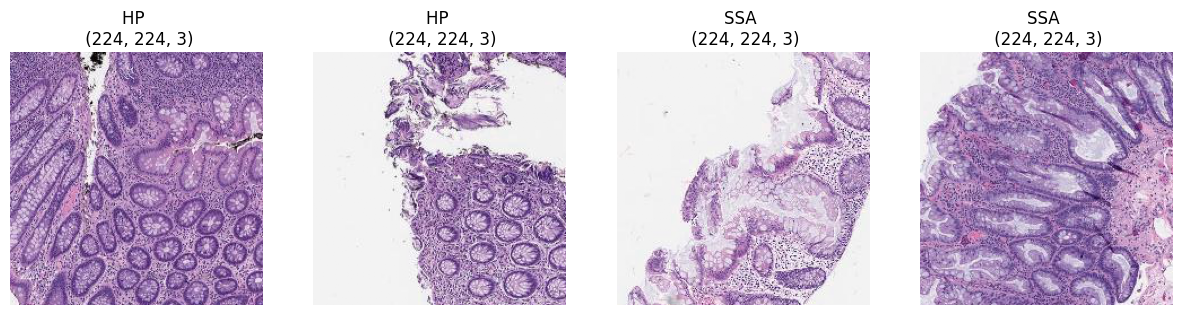

In [ ]:
#@title **Ejemplos del dataset**

muestras = pd.concat([df[df['label']=='HP'].sample(2),
                      df[df['label']=='SSA'].sample(2)])

plt.figure(figsize=(15, 15))

for i, (idx, row) in enumerate(muestras.iterrows()):
    plt.subplot(1, 4, i+1)

    # Cargar y mostrar
    ruta = os.path.join(IMG_DIR, row['image_path'])
    img = plt.imread(ruta)

    plt.imshow(img)

    plt.title(f"{row['label']} \n {img.shape}")
    plt.axis('off')

plt.show()

In [ ]:
#@title **Preparar dataset dependiendo del modelo**

def preparar_datasets(df_train, df_val, df_test, preprocess_func, batch_size=32, img_size=(224, 224)):

    AUTOTUNE = tf.data.AUTOTUNE

    # --- 1. Definir función de carga interna ---
    def load_image(image_path, label):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, img_size)
        img = tf.cast(img, tf.float32)

        if preprocess_func:
            img = preprocess_func(img)

        return img, label

    df_hp = df_train[df_train['num_label'] == 0]
    df_ssa = df_train[df_train['num_label'] == 1]

    ds_hp = tf.data.Dataset.from_tensor_slices((df_hp['image_full_path'].values, df_hp['num_label'].values))
    ds_ssa = tf.data.Dataset.from_tensor_slices((df_ssa['image_full_path'].values, df_ssa['num_label'].values))

    ds_hp = ds_hp.map(load_image, num_parallel_calls=AUTOTUNE)
    ds_ssa = ds_ssa.map(load_image, num_parallel_calls=AUTOTUNE)

    balanced_ds = tf.data.Dataset.sample_from_datasets(
        [ds_hp.repeat(), ds_ssa.repeat()],
        weights=[0.5, 0.5]
    )

    train_ds = balanced_ds.shuffle(1000).batch(batch_size).prefetch(AUTOTUNE)

    val_ds = tf.data.Dataset.from_tensor_slices((df_val['image_full_path'].values, df_val['num_label'].values))
    val_ds = val_ds.map(load_image, num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(AUTOTUNE)

    pasos = len(df_hp) // batch_size

    test_ds = tf.data.Dataset.from_tensor_slices((df_test['image_full_path'].values, df_test['num_label'].values))
    test_ds = test_ds.map(load_image, num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.batch(batch_size).prefetch(AUTOTUNE)

    return train_ds, val_ds, test_ds, pasos

df_train_sub, df_val = train_test_split(
    df_train,
    test_size=0.1,
    random_state=42,
    stratify=df_train['num_label']
)

In [ ]:
#@title **Data Augmentation**
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
], name="data_augmentation")

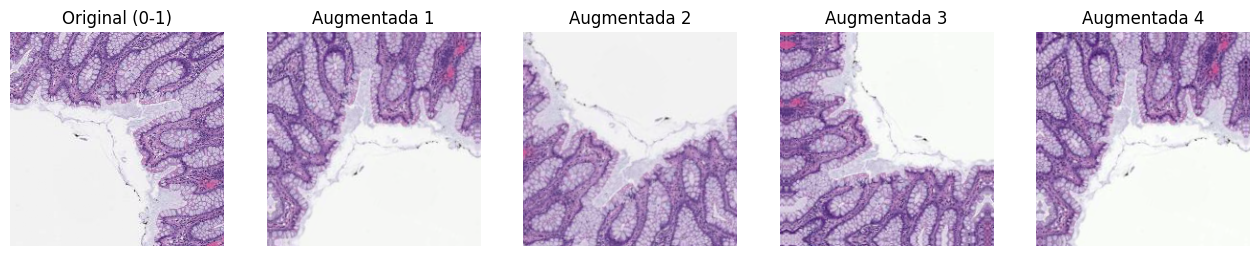

In [ ]:
#@title **Visualizar imágenes aumentadas**

def imagen_aug(df, modelo_aug):

    ruta = random.choice(df['image_full_path'].values)

    img_raw = tf.io.read_file(ruta)
    img = tf.image.decode_png(img_raw, channels=3)

    img = tf.image.resize(img, (224, 224))

    img = img / 255.0

    img_batch = tf.expand_dims(img, 0)

    plt.figure(figsize=(16, 6))

    plt.subplot(1, 5, 1)
    plt.imshow(img)
    plt.title("Original (0-1)")
    plt.axis('off')

    for i in range(4):
        aug_img = modelo_aug(img_batch, training=True)[0]

        aug_img = tf.clip_by_value(aug_img, 0.0, 1.0)

        plt.subplot(1, 5, i + 2)
        plt.imshow(aug_img)
        plt.title(f"Augmentada {i+1}")
        plt.axis('off')

    plt.show()

imagen_aug(df_train, data_augmentation)

In [ ]:
#@title **Función para graficar**

def graficas(history, titulo="Modelo"):
    metrics = history.history
    epochs = range(1, len(metrics['loss']) + 1)

    fig, axes = plt.subplots(3, 2, figsize=(16, 15))
    fig.suptitle(f'{titulo}', fontsize=20, color='#555555')

    ax = axes.flatten()

    ax[0].plot(epochs, metrics['loss'], 'o-', color='#ffadad', label='Train', linewidth=2.5)
    ax[0].plot(epochs, metrics['val_loss'], 'o-', color='#ff6f69', label='Val', linewidth=2.5)
    ax[0].set_title('Loss', fontsize=14, fontweight='bold', color='#d9534f')

    best_epoch = np.argmin(metrics['val_loss'])
    best_val = metrics['val_loss'][best_epoch]
    ax[0].scatter(best_epoch + 1, best_val, s=150, c='red', marker='*', label=f'Best: {best_val:.4f}')

    acc_key = 'accuracy' if 'accuracy' in metrics else 'acc'
    val_acc_key = 'val_accuracy' if 'val_accuracy' in metrics else 'val_acc'

    if acc_key in metrics:
        ax[1].plot(epochs, metrics[acc_key], 'o-', color='#a0c4ff', label='Train', linewidth=2.5)
        ax[1].plot(epochs, metrics[val_acc_key], 'o-', color='#5e97f6', label='Val', linewidth=2.5)
        ax[1].set_title('Accuracy', fontsize=14, fontweight='bold', color='#428bca')

        best_epoch = np.argmax(metrics[val_acc_key])
        best_val = metrics[val_acc_key][best_epoch]
        ax[1].scatter(best_epoch + 1, best_val, s=150, c='blue', marker='*', label=f'Best: {best_val:.4f}')

    if 'auc' in metrics:
        ax[2].plot(epochs, metrics['auc'], 'o-', color='#91ba89', label='Train', linewidth=2.5)
        ax[2].plot(epochs, metrics['val_auc'], 'o-', color='#00b83c', label='Val', linewidth=2.5)
        ax[2].set_title('AUC - ROC', fontsize=14, fontweight='bold', color='#5cb879')

        best_epoch = np.argmax(metrics['val_auc'])
        best_val = metrics['val_auc'][best_epoch]
        ax[2].scatter(best_epoch + 1, best_val, s=150, c='green', marker='*', label=f'Best: {best_val:.4f}')

    if 'recall' in metrics:
        ax[3].plot(epochs, metrics['recall'], 'o-', color='#bdb2ff', label='Train', linewidth=2.5)
        ax[3].plot(epochs, metrics['val_recall'], 'o-', color='#6c5ce7', label='Val', linewidth=2.5)
        ax[3].set_title('Recall', fontsize=14, fontweight='bold', color='#8e44ad')

    if 'f1_metric' in metrics:
        ax[4].plot(epochs, metrics['f1_metric'], 'o-', color='#ffd6a5', label='Train', linewidth=2.5)
        ax[4].plot(epochs, metrics['val_f1_metric'], 'o-', color='#ff9f43', label='Val', linewidth=2.5)
        ax[4].set_title('F1-Score', fontsize=14, fontweight='bold', color='#f0ad4e')

        best_epoch = np.argmax(metrics['val_f1_metric'])
        best_val = metrics['val_f1_metric'][best_epoch]
        ax[4].scatter(best_epoch + 1, best_val, s=150, c='orange', marker='*', label=f'Best: {best_val:.4f}')

    for i in range(6):
        if i == 5:
            fig.delaxes(ax[i])
            continue

        if ax[i].has_data():
            ax[i].legend(loc='best', frameon=True)
            ax[i].grid(True, alpha=0.3, linestyle='--')
            ax[i].set_xlabel('Épocas')
            ax[i].set_facecolor('#fafafa')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    from clearml import Logger
    try:
        Logger.current_logger().report_matplotlib_figure(
            title=titulo,
            series="Métricas Entrenamiento",
            figure=fig
        )
    except:
        pass

    plt.show()

In [ ]:
#@title **Función para evaluar el modleo**
def evaluar_modelo(modelo, dataset, nombre_modelo="Modelo"):

    print(f" Evaluando: {nombre_modelo}...")

    y_pred_probs = modelo.predict(dataset, verbose=1)

    y_pred = (y_pred_probs > 0.5).astype(int)

    y_true = np.concatenate([y for x, y in dataset], axis=0)

    try:
        auc = roc_auc_score(y_true, y_pred_probs)
        print(f"\n AUC-ROC Score: {auc:.4f}")
    except:
        print("\nNo se pudo calcular AUC")

    print("\nReporte Detallado:\n")
    print(classification_report(y_true, y_pred, target_names=['HP', 'SSA']))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='PuRd', cbar=False,
                annot_kws={"size": 14}, linewidths=1, linecolor='white')

    plt.title(f'Matriz de Confusión: {nombre_modelo}', fontsize=14, color='#660024', fontweight='bold')
    plt.xlabel('Predicción del Modelo', fontsize=12)
    plt.ylabel('Etiqueta Real', fontsize=12)

    plt.xticks([0.5, 1.5], ['HP', 'SSA'], fontsize=11)
    plt.yticks([0.5, 1.5], ['HP', 'SSA'], fontsize=11, rotation=0)

    plt.show()

    return y_true, y_pred, y_pred_probs

In [ ]:
#@title **Subir resultados a ClearML

def subir_resultados_test_clearml(y_true, y_pred, probs, task, etiquetas=['HP', 'SSA']):

    print("Subiendo resultados de TEST a ClearML...")

    cm = confusion_matrix(y_true, y_pred)

    Logger.current_logger().report_matrix(
        title="Matriz de Confusion (TEST)",
        series="Test Set",
        matrix=cm,
        iteration=0,
        xaxis=etiquetas,
        yaxis=etiquetas
    )


    df_resultados = pd.DataFrame({
        'Real': np.array(y_true).flatten(),
        'Prediccion': np.array(y_pred).flatten(),
        'Probabilidad': np.array(probs).flatten()
    })

    task.upload_artifact(
        name='Predicciones_TEST',
        artifact_object=df_resultados
    )

    print("¡Resultados de Test subidos exitosamente!")

# **Modelo DenseNet201**


In [ ]:
def modelo_densenet201(train_ds, val_ds, pasos):

    inputs = tf.keras.Input(shape=(224, 224, 3))

    x = data_augmentation(inputs)

    base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    base_model.trainable = False

    x = base_model(x, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x) #aquí si
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs, name="densenet201")

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.AUC(name='auc'),
                           tf.keras.metrics.Recall(name='recall'),
                           f1_metric])

    model.fit(train_ds,
              epochs=6,
              validation_data=val_ds,
              steps_per_epoch=pasos,
              verbose=1)

    base_model.trainable = True

    for layer in base_model.layers[:-40]:
        layer.trainable = False

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.AUC(name='auc'),
                           tf.keras.metrics.Recall(name='recall'),
                           f1_metric])

    checkpoint_path = os.path.join(ruta_modelos, 'densenet201_v2_1.keras')
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=8, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            save_best_only=True,
            monitor='val_auc',
            mode='max',
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4),
        TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]

    print("Fine Tuning")
    history = model.fit(
        train_ds,
        epochs=30,
        validation_data=val_ds,
        steps_per_epoch=pasos,
        callbacks=callbacks
    )

    return model, history

In [ ]:
#@title **Entrenar DenseNet201**

config_dense = {
    "base_model": "DenseNet201",
    "img_size": (224, 224),
    "batch_size": 32,
    "learning_rate_warmup": 1e-3,
    "learning_rate_finetuning": 1e-5,
    "epochs_warmup": 6,
    "epochs_finetuning": 30,
    "optimizer": "Adam",
    "loss": "binary_crossentropy",
    "augmentation": True
}

preprocess_densenet = densenet.preprocess_input


task_dense = iniciar_experimento(
    nombre_modelo='DenseNet201',
    config=config_dense,
    tags_extra=['Experimento_2'],
    proyecto="Polipos MHIST"
)

train_dense, val_dense, pasos_dense = preparar_datasets(
    df_train_sub,
    df_val,
    preprocess_func=preprocess_densenet
)

print(f"Pasos por época: {pasos_dense}")

model_densenet201, history_densenet201 = modelo_densenet201(train_dense, val_dense, pasos_dense)

ClearML Task: created new task id=495c797945fd4bd18312f8469867c603


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


ClearML results page: https://app.clear.ml/projects/99ef0f6b48004f8ba560c38b73da254b/experiments/495c797945fd4bd18312f8469867c603/output/log
Experimento 'Entrenamiento DenseNet201' iniciado en ClearML
Pasos por época: 43
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/6
43/43 ━━━━━━━━━━━━━━━━━━━━ 53s 531ms/step - accuracy: 0.5888 - auc: 0.6470 - f1_metric: 0.5635 - loss: 0.7230 - recall: 0.5517 - val_accuracy: 0.4908 - val_auc: 0.8724 - val_f1_metric: 0.5340 - val_loss: 0.8902 - val_recall: 1.0000
Epoch 2/6
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 312ms/step - accuracy: 0.6836 - auc: 0.7439 - f1_metric: 0.6938 - loss: 0.6298 - recall: 0.7036 - val_accuracy: 0.5642 - val_auc: 0.8994 - val_f1_metric: 0.5723 - val_loss: 0.6992 - val_recall: 0.9841
Epoch 3/6
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 328ms/step - accuracy: 0.7285 - auc: 0.7965 - f1_metric: 0.7205 - loss: 0.5696 - recall: 0.7581 - val_accuracy: 0.6972 - val_auc: 0.9215 - val_f1_metric: 0.6559 - val_loss: 0.5485 - val_recall: 0.9683
Ep

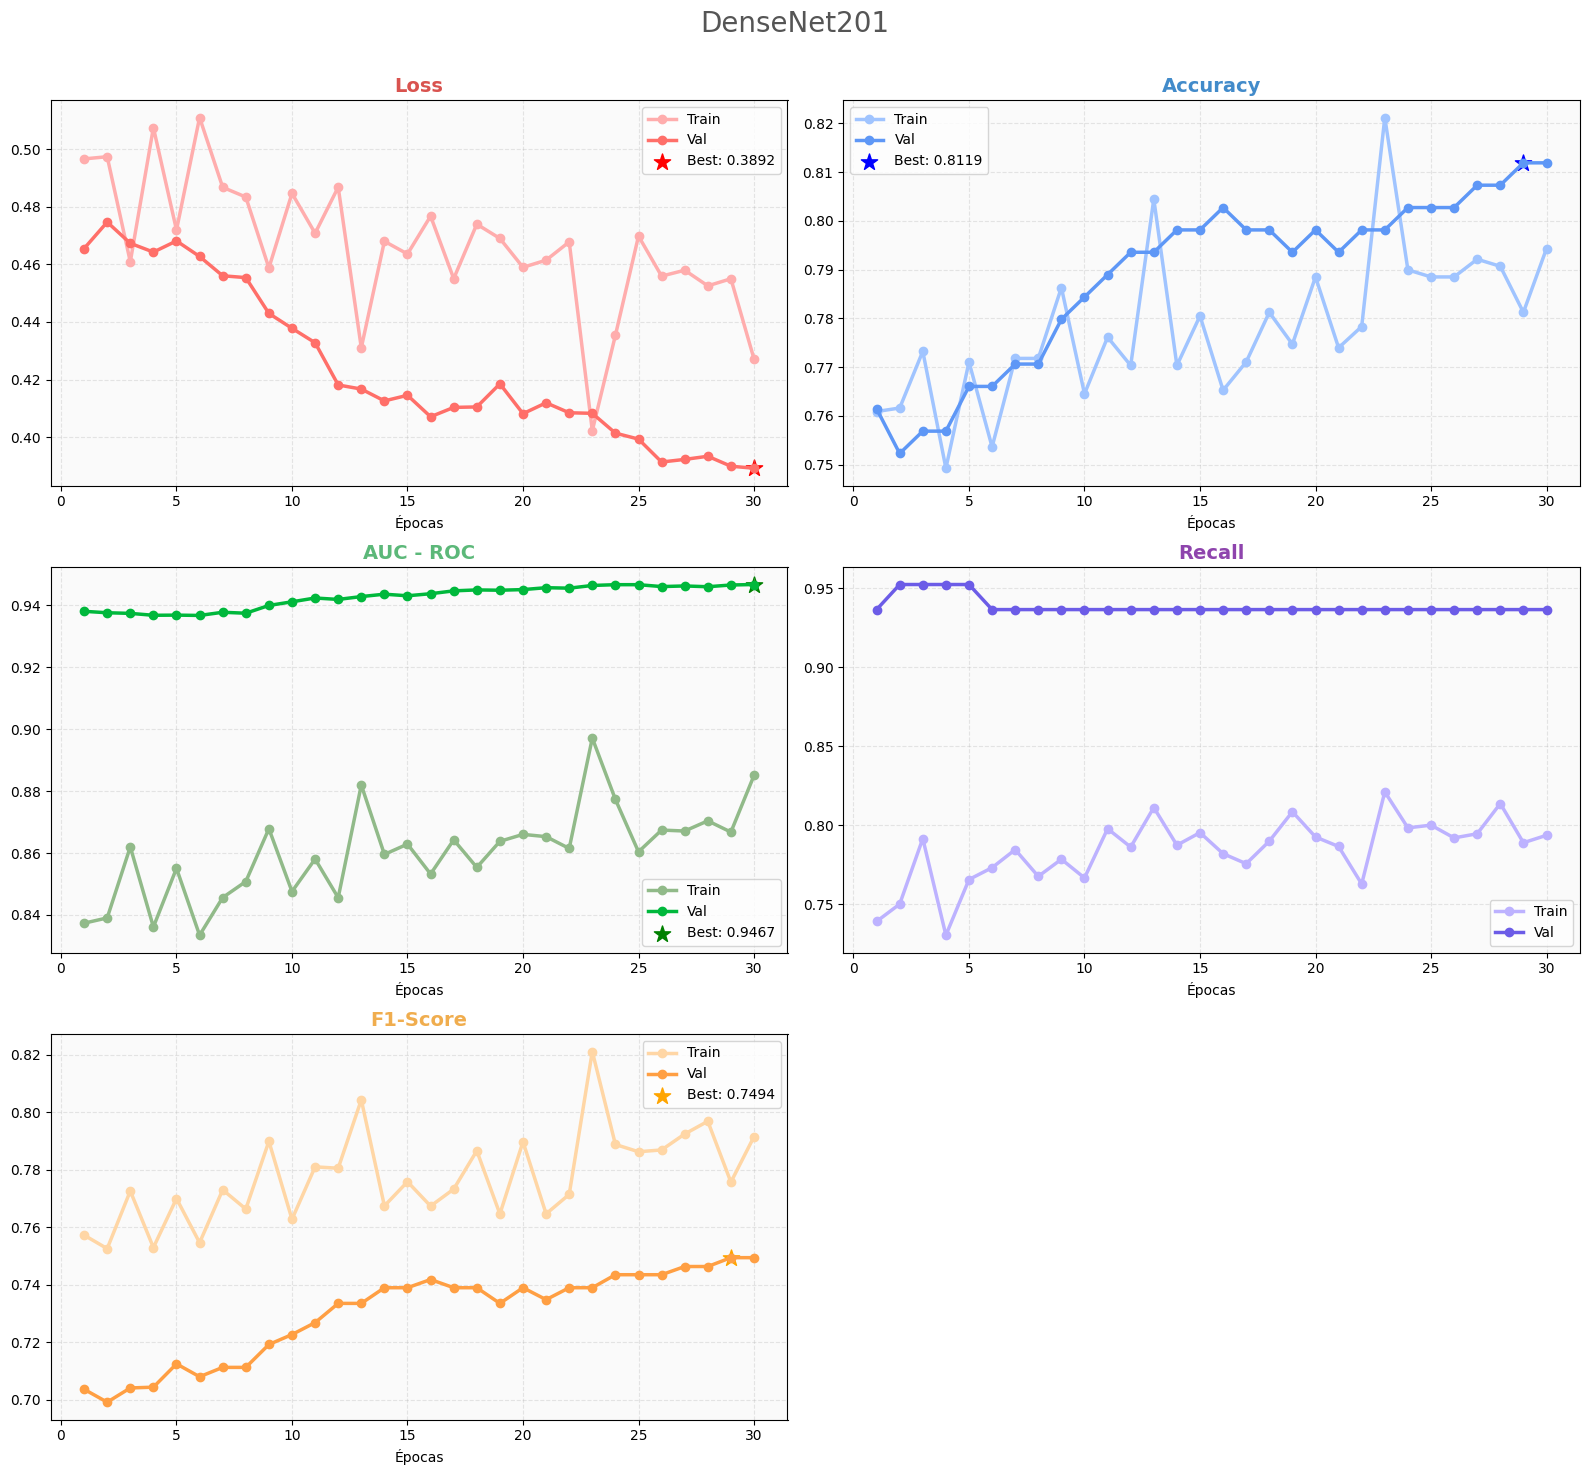

In [ ]:
graficas(history_densenet201, "DenseNet201")

 Evaluando: DenseNet201...
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 264ms/step

🌟 AUC-ROC Score: 0.8905

Reporte Detallado:

               precision    recall  f1-score   support

    HP (Sano)       0.95      0.64      0.77       617
SSA (Peligro)       0.61      0.94      0.74       360

     accuracy                           0.75       977
    macro avg       0.78      0.79      0.75       977
 weighted avg       0.82      0.75      0.76       977



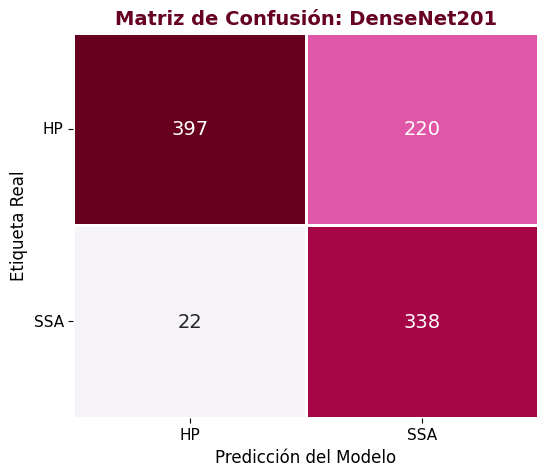

In [ ]:
#@title **Evaluar modelo Resnet50**

y_true, y_pred, probs = evaluar_modelo(model_densenet201, test_dense, "DenseNet201")

subir_resultados_test_clearml(
    y_true,
    y_pred,
    probs,
    task_dense,
    etiquetas=['HP', 'SSA']
)

task_dense.close()

# **Modelo ResNet50**

In [ ]:
def modelo_resnet50(train_ds, val_ds, pasos):

    inputs = tf.keras.Input(shape=(224, 224, 3))

    x = data_augmentation(inputs)

    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    base_model.trainable = False

    x = base_model(x, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="ResNet50")

    print("--- 🧊 Fase 1: Calentamiento (Solo cabezal) ---")
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.AUC(name='auc'),
                           tf.keras.metrics.Recall(name='recall'),
                           f1_metric])

    model.fit(train_ds,
              epochs=6,
              validation_data=val_ds,
              steps_per_epoch=pasos,
              verbose=1)

    print("Fine Tuning")

    base_model.trainable = True

    for layer in base_model.layers[:-35]:
        layer.trainable = False

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.AUC(name='auc'),
                           tf.keras.metrics.Recall(name='recall'),
                           f1_metric])


    checkpoint_path = os.path.join(ruta_modelos, 'resNet50_v2_2.keras')
    log_dir = "logs/fit/resnet50_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path, save_best_only=True, monitor='val_auc', mode='max', verbose=1
        ),
        TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]

    history = model.fit(
        train_ds,
        epochs=30,
        validation_data=val_ds,
        steps_per_epoch=pasos,
        callbacks=callbacks
    )

    return model, history

In [ ]:
#@title **Entrenar resnet50**

config_resnet = {
    "base_model": "Resnet50",
    "img_size": (224, 224),
    "batch_size": 32,
    "learning_rate_warmup": 1e-3,
    "learning_rate_finetuning": 1e-5,
    "epochs_warmup": 6,
    "epochs_finetuning": 30,
    "optimizer": "Adam",
    "loss": "binary_crossentropy",
    "augmentation": True
}

preprocess_resnet = resnet50.preprocess_input

task_resnet = iniciar_experimento(
    nombre_modelo='ResNet50',
    config=config_resnet,
    tags_extra=['Experimento_2'],
    proyecto="Polipos MHIST"
)

train_resnet, val_resnet, test_resnet, pasos_resnet = preparar_datasets(
    df_train_sub,
    df_val,
    df_test,
    preprocess_func=preprocess_resnet
)

print(f"Pasos por época calculados: {pasos_resnet}")

model_resnet50, history_resnet50 = modelo_resnet50(
    train_resnet,
    val_resnet,
    pasos_resnet
)

ClearML Task: created new task id=b7c447a64d5f4aa78965b64d04d570b9
ClearML results page: https://app.clear.ml/projects/99ef0f6b48004f8ba560c38b73da254b/experiments/b7c447a64d5f4aa78965b64d04d570b9/output/log
Experimento 'Entrenamiento ResNet50' iniciado en ClearML
Pasos por época calculados: 43
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
--- 🧊 Fase 1: Calentamiento (Solo cabezal) ---
Epoch 1/6
43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 319ms/step - accuracy: 0.5730 - auc: 0.5931 - f1_metric: 0.5601 - loss: 0.8162 - recall: 0.5901 - val_accuracy: 0.6972 - val_auc: 0.8276 - val_f1_metric: 0.6394 - val_loss: 0.5883 - val_recall: 0.9048
Epoch 2/6
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - accuracy: 0.6572 - auc: 0.7255 - f1_metric: 0.6683 - loss: 0.6474 - recall: 0.6868 - val_accuracy: 0.7248 - val_auc: 0.8749 - val_f1_metric: 0.6646 - val_loss: 0.5234 - val_recall: 0.9206
Epoch 3/6
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.7065 - auc: 0.7536 - f1_metric: 0.6888 - loss: 0.6229 - 

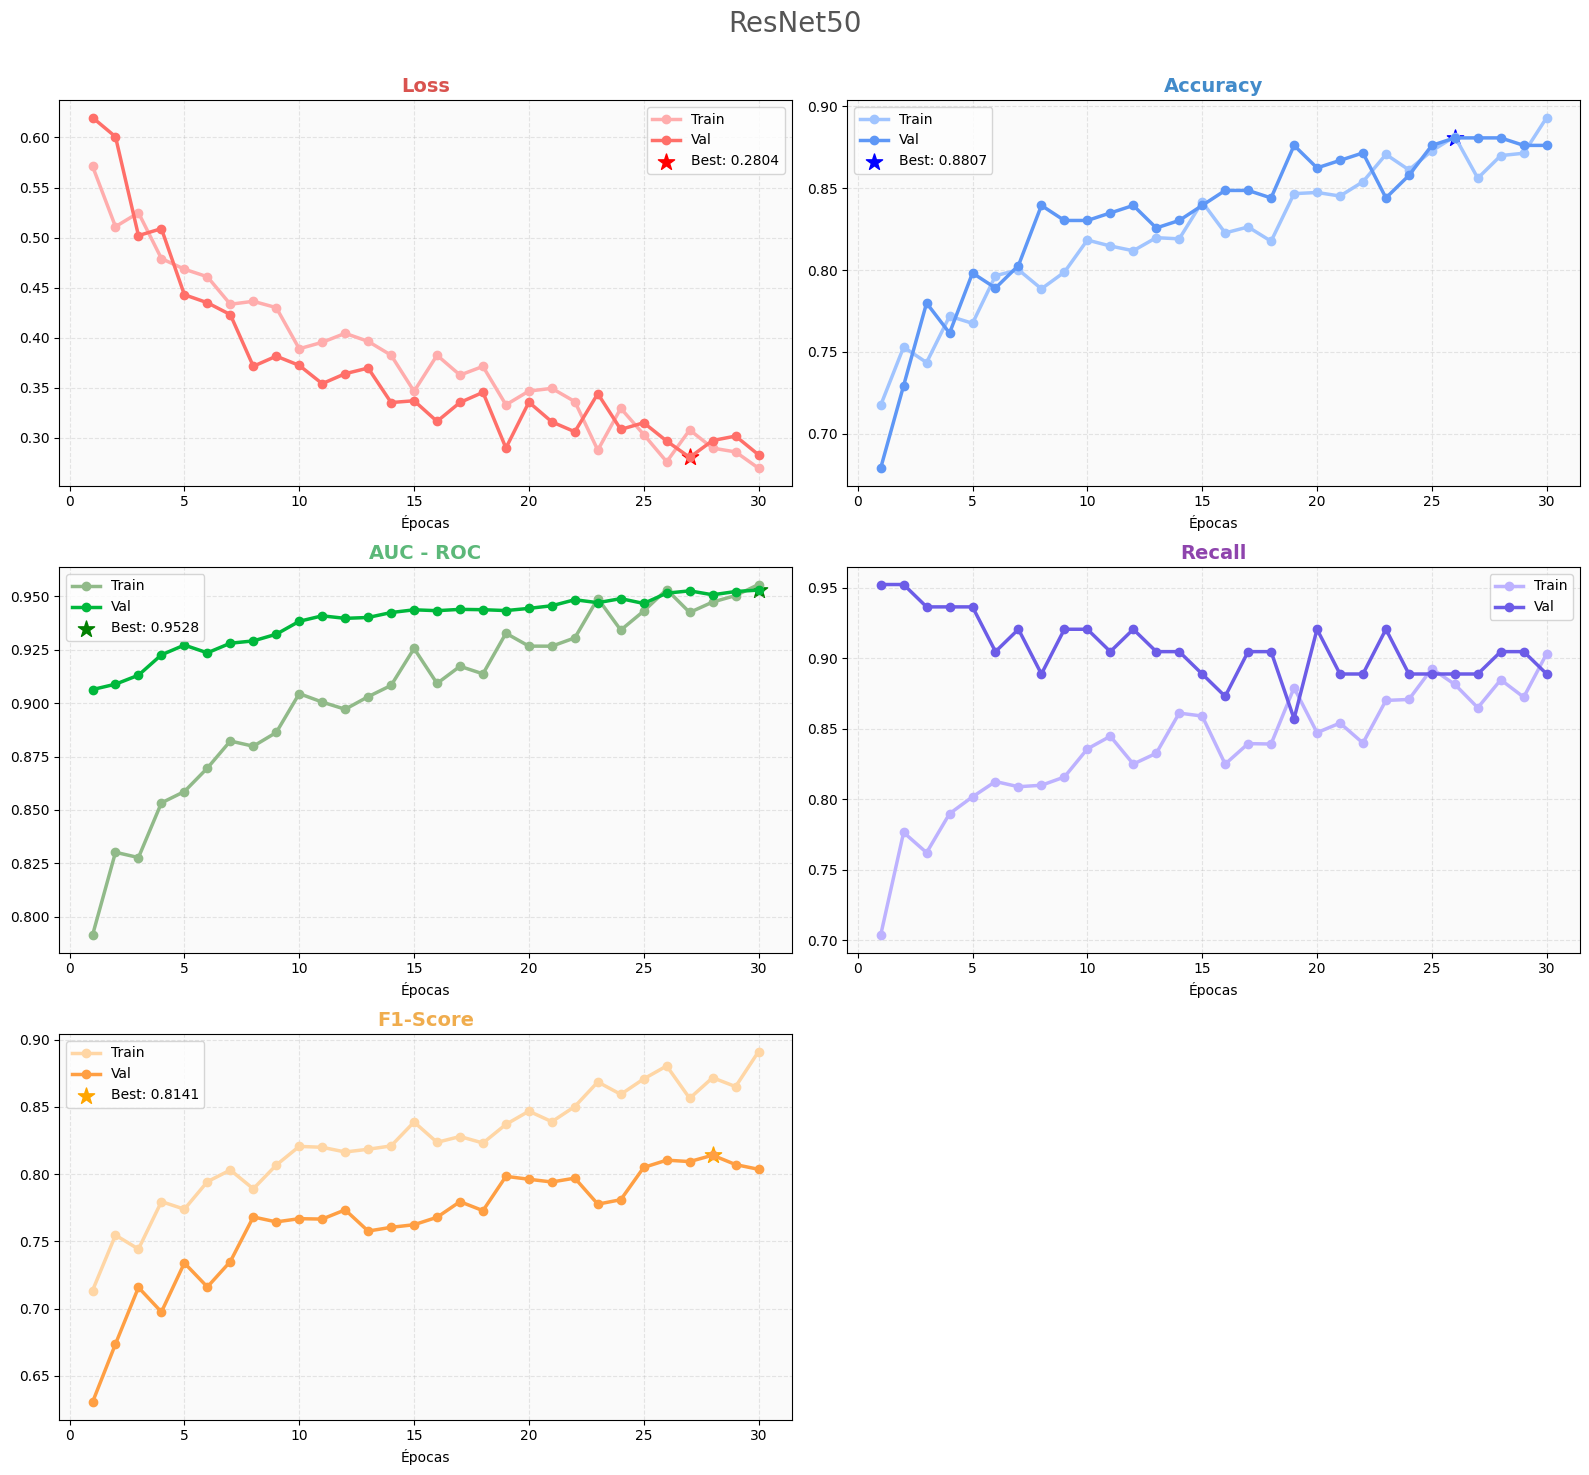

In [ ]:
#@title **Graficar Resnet50**
graficas(history_resnet50, "ResNet50")

In [ ]:

def graficar_comparacion_test(model, test_ds, history, titulo="Comparativa Final"):

    test_results = model.evaluate(test_ds, verbose=0)

    # 2. Obtener métricas finales de TRAIN y VAL (del último epoch)
    metrics = history.history

    # Extraemos el último valor de cada lista
    # Nota: Asegúrate de que las claves coincidan con cómo las guardaste (f1_metric vs f1_score)
    train_metrics = [
        metrics['loss'][-1],
        metrics.get('accuracy', metrics.get('acc'))[-1],
        metrics.get('auc', [0])[-1],
        metrics.get('recall', [0])[-1],
        metrics.get('f1_metric', [0])[-1]
    ]

    val_metrics = [
        metrics['val_loss'][-1],
        metrics.get('val_accuracy', metrics.get('val_acc'))[-1],
        metrics.get('val_auc', [0])[-1],
        metrics.get('val_recall', [0])[-1],
        metrics.get('val_f1_metric', [0])[-1]
    ]


    labels = ['Loss', 'Accuracy', 'AUC', 'Recall', 'F1-Score']
    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 7))

    rects1 = ax.bar(x - width, train_metrics, width, label='Train', color='#afa0ff')
    rects2 = ax.bar(x, val_metrics, width, label='Validation', color='#ffd6a5')
    rects3 = ax.bar(x + width, test_results, width, label='TEST', color='#96dce3')

    ax.set_ylabel('Valor (0-1)')
    ax.set_title(f'Entrenamiento vs Validación vs Test\n({titulo})', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    plt.tight_layout()
    plt.show()

    return test_results



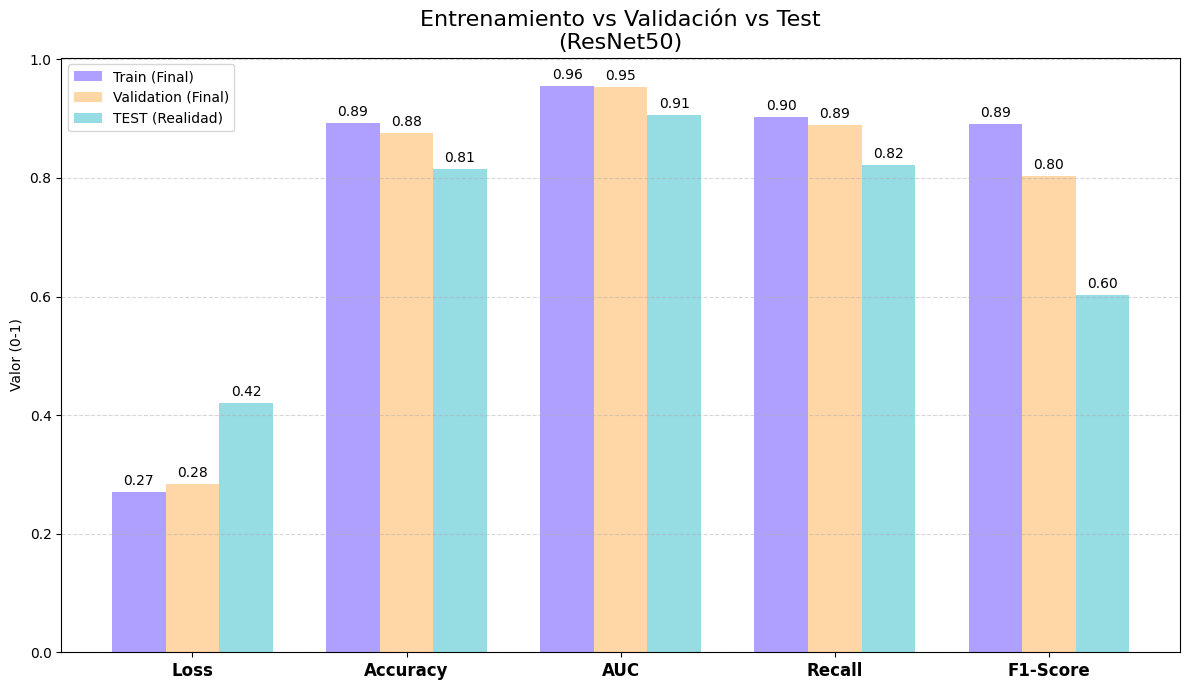

In [ ]:
#@title
resultados_test = graficar_comparacion_test(model_resnet50, test_resnet, history_resnet50, titulo="ResNet50")

 Evaluando: Resnet50...
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step

🌟 AUC-ROC Score: 0.9054

Reporte Detallado:

              precision    recall  f1-score   support

          HP       0.89      0.81      0.85       617
         SSA       0.72      0.82      0.77       360

    accuracy                           0.81       977
   macro avg       0.80      0.82      0.81       977
weighted avg       0.82      0.81      0.82       977



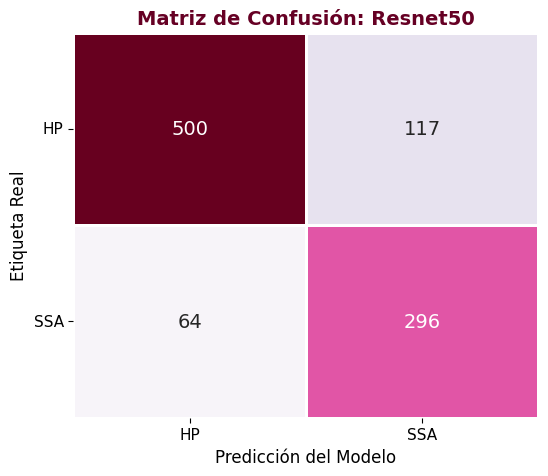

Subiendo resultados de TEST a ClearML...


/usr/local/lib/python3.12/dist-packages/clearml/logger.py:771: DeprecationWarning:

:meth:`Logger.report_matrix` is deprecated; use :meth:`Logger.report_confusion_matrix` instead.



¡Resultados de Test subidos exitosamente!


In [ ]:
#@title **Evaluar modelo Resnet50**

y_true, y_pred, probs = evaluar_modelo(model_resnet50, test_resnet, "Resnet50")

subir_resultados_test_clearml(
    y_true,
    y_pred,
    probs,
    task_resnet,
    etiquetas=['HP', 'SSA']
)

#task_resnet.close()

In [ ]:
task_resnet.close()

# **Modelo Xception**

In [ ]:
def modelo_xception(train_ds, val_ds, pasos):

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)

    #imputs -1 1
    #x = tf.keras.applications.xception.preprocess_input(x)

    base_model = Xception(include_top=False, weights='imagenet', input_tensor=x)
    base_model.trainable = False

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="Xception")

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.AUC(name='auc'),
                           tf.keras.metrics.Recall(name='recall'),
                           f1_metric])

    model.fit(train_ds,
              epochs=6,
              validation_data=val_ds,
              steps_per_epoch=pasos,
              verbose=1)

    base_model.trainable = True

    for layer in base_model.layers[:-45]:
        layer.trainable = False

    for layer in base_model.layers:
        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = False

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.AUC(name='auc'),
                           tf.keras.metrics.Recall(name='recall'),
                           f1_metric])

    checkpoint_path = os.path.join(ruta_modelos, 'xception_v2_1.keras')
    log_dir = "logs/fit/xception_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=8, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_auc', mode='max', verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]

    history = model.fit(
        train_ds,
        epochs=30,
        validation_data=val_ds,
        steps_per_epoch=pasos,
        callbacks=callbacks
    )

    return model, history

In [ ]:
#@title **Entrenar xception**

# 1. Configuración
config_xception = {
    "base_model": "Xception",
    "img_size": (224, 224),
    "batch_size": 32,
    "learning_rate_warmup": 1e-3,
    "learning_rate_finetuning": 1e-5,
    "epochs_warmup": 6,
    "epochs_finetuning": 30,
    "optimizer": "Adam",
    "loss": "binary_crossentropy",
    "augmentation": True
}

task_xception = iniciar_experimento(
    nombre_modelo='Xception',
    config=config_xception,
    tags_extra=['Experimento_2'],
    proyecto="Polipos MHIST"
)


preprocess_xception = xception.preprocess_input

train_xception, val_xception, test_xception, pasos_xception = preparar_datasets(
    df_train_sub,
    df_val,
    df_test,
    preprocess_func=preprocess_xception
)


model_xception, history_xception = modelo_xception(
    train_xception,
    val_xception,
    pasos_xception
)

ClearML Task: created new task id=2cf7c05cc8904657bb3e4ecae6340c23
ClearML results page: https://app.clear.ml/projects/99ef0f6b48004f8ba560c38b73da254b/experiments/2cf7c05cc8904657bb3e4ecae6340c23/output/log
Experimento 'Entrenamiento Xception' iniciado en ClearML
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/6
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 255ms/step - accuracy: 0.6053 - auc: 0.6490 - f1_metric: 0.5653 - loss: 0.6574 - recall: 0.5783 - val_accuracy: 0.6881 - val_auc: 0.8610 - val_f1_metric: 0.6417 - val_loss: 0.5497 - val_recall: 0.9206
Epoch 2/6
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.6856 - auc: 0.7588 - f1_metric: 0.7055 - loss: 0.5802 - recall: 0.7573 - val_accuracy: 0.6927 - val_auc: 0.8821 - val_f1_metric: 0.6483 - val_loss: 0.5429 - val_recall: 0.9365
Epoch 3/6
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.7002 - auc: 0.7747 - f1_metric: 0.6865 - loss: 0.5624 - recall: 0.7215 - val_accuracy: 0.7202 - val_auc: 0.8980 - val_f1_metric: 0.6772

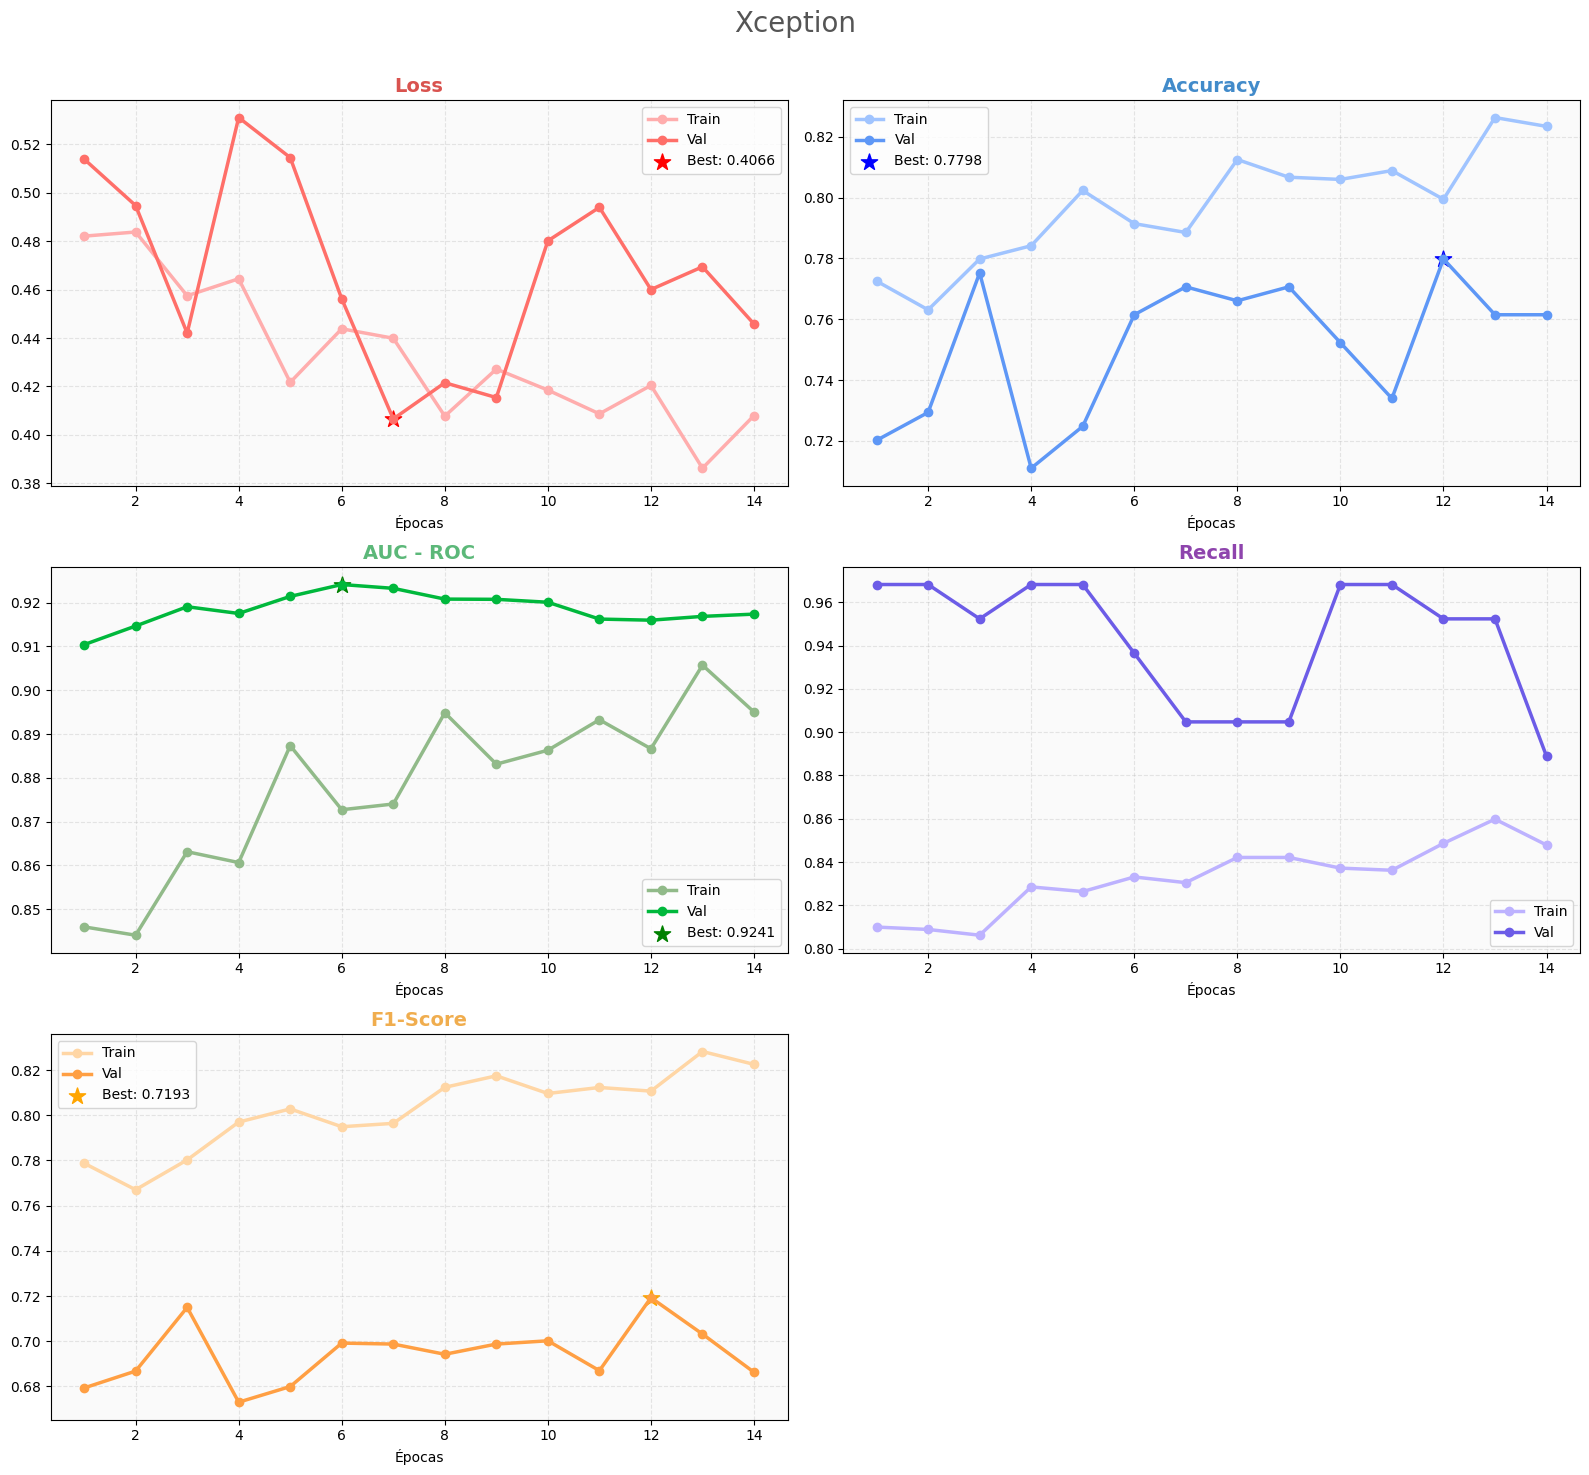

In [ ]:
graficas(history_xception, "Xception")

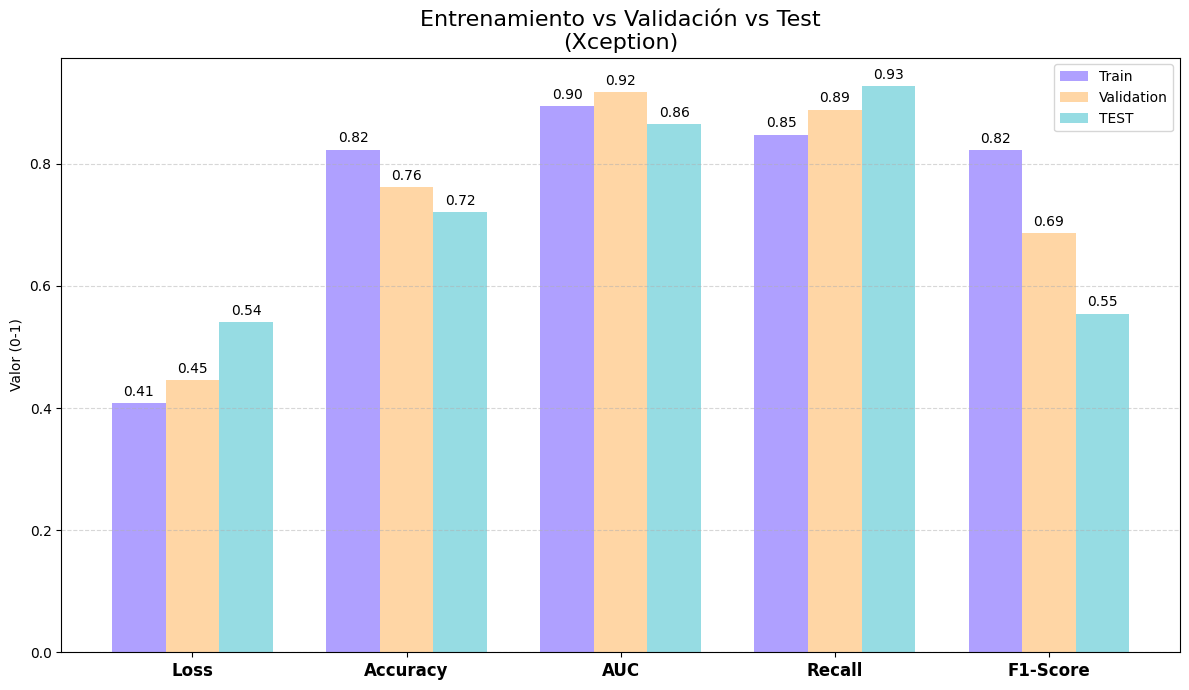

In [ ]:
resultados_test_xception = graficar_comparacion_test(model_xception, test_xception, history_xception, titulo="Xception")

 Evaluando: Xception...
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 216ms/step

🌟 AUC-ROC Score: 0.8646

Reporte Detallado:

              precision    recall  f1-score   support

          HP       0.93      0.60      0.73       617
         SSA       0.57      0.93      0.71       360

    accuracy                           0.72       977
   macro avg       0.75      0.76      0.72       977
weighted avg       0.80      0.72      0.72       977



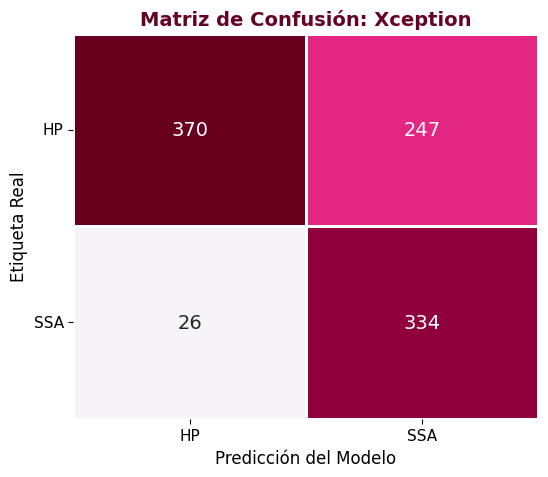

Subiendo resultados de TEST a ClearML...


/usr/local/lib/python3.12/dist-packages/clearml/logger.py:771: DeprecationWarning:

:meth:`Logger.report_matrix` is deprecated; use :meth:`Logger.report_confusion_matrix` instead.



¡Resultados de Test subidos exitosamente!


In [ ]:
#@title **Evaluar Xception Final**

y_true_xc, y_pred_xc, probs_xc = evaluar_modelo(model_xception, test_xception, "Xception")

subir_resultados_test_clearml(
    y_true_xc,
    y_pred_xc,
    probs_xc,
    task_xception,
    etiquetas=['HP', 'SSA']
)

#task_xception.close()

In [ ]:
task_xception.close()

In [ ]:
#@title **Ensamble de modelos**

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
#@title **2. Motor de Predicción Secuencial**

def obtener_predicciones_individuales(df_test, img_dir, lista_modelos_info):

    paths = df_test['image_path'].apply(lambda x: os.path.join(img_dir, x)).values
    labels = df_test['num_label'].values

    predicciones_dict = {}

    for nombre, ruta_modelo, preprocess_func in lista_modelos_info:
        print(f"🔄 Procesando modelo: {nombre}...")

        def load_img(path, label):
            img = tf.io.read_file(path)
            img = tf.image.decode_png(img, channels=3)
            img = tf.image.resize(img, (224, 224))
            img = tf.cast(img, tf.float32)
            if preprocess_func:
                img = preprocess_func(img)
            return img, label

        ds = tf.data.Dataset.from_tensor_slices((paths, labels))
        ds = ds.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(32).prefetch(tf.data.AUTOTUNE)

        print(f"Pesos desde: {ruta_modelo}")
        try:
            model = load_model(ruta_modelo, custom_objects={'f1_metric': f1_metric})

            # C. Predecir
            print(f"   🔮 Predicciones...")
            probs = model.predict(ds, verbose=1)
            predicciones_dict[nombre] = probs

            # D. Limpiar Memoria (CRÍTICO)
            del model
            tf.keras.backend.clear_session()
            import gc
            gc.collect()
            print(f"   ✅ {nombre} completado\n")

        except Exception as e:
            print(f"   ❌ ERROR cargando {nombre}: {e}")

    return predicciones_dict, labels

IMG_DIR = "/content/drive/MyDrive/proyecto_ia/dataset_polipos/images" # Ajusta tu ruta
CSV_PATH = "/content/drive/MyDrive/proyecto_ia/dataset_polipos/annotations.csv" # Tu CSV original

info_modelos = [
    ("DenseNet201", "/content/drive/MyDrive/proyecto_ia/modelos_entrenados/densenet201_v2_1.keras", tf.keras.applications.densenet.preprocess_input),
    ("ResNet50",    "/content/drive/MyDrive/proyecto_ia/modelos_entrenados/resNet50_v2_2.keras",    tf.keras.applications.resnet50.preprocess_input),
    ("Xception",    "/content/drive/MyDrive/proyecto_ia/modelos_entrenados/xception_v2_1.keras",    tf.keras.applications.xception.preprocess_input)
]


df = pd.read_csv(CSV_PATH)
df = df.rename(columns={'Image Name': 'image_path', 'Majority Vote Label': 'label'})
df['num_label'] = df['label'].map({'HP': 0, 'SSA': 1})
df_test = df[df['Partition'] == 'test']

preds_individuales, y_true = obtener_predicciones_individuales(df_test, IMG_DIR, info_modelos)

🔄 Procesando modelo: DenseNet201...
Pesos desde: /content/drive/MyDrive/proyecto_ia/modelos_entrenados/densenet201_v2_1.keras
   🔮 Predicciones...
31/31 ━━━━━━━━━━━━━━━━━━━━ 385s 12s/step
   ✅ DenseNet201 completado

🔄 Procesando modelo: ResNet50...
Pesos desde: /content/drive/MyDrive/proyecto_ia/modelos_entrenados/resNet50_v2_2.keras
   🔮 Predicciones...
31/31 ━━━━━━━━━━━━━━━━━━━━ 189s 6s/step
   ✅ ResNet50 completado

🔄 Procesando modelo: Xception...
Pesos desde: /content/drive/MyDrive/proyecto_ia/modelos_entrenados/xception_v2_1.keras
   🔮 Predicciones...
31/31 ━━━━━━━━━━━━━━━━━━━━ 219s 7s/step
   ✅ Xception completado



In [ ]:
#@title **Calcular Ensamble y Métricas**

def calcular_ensamble(preds_dict, pesos=None):

    if pesos is None:
        #Pesos iguales
        pesos = [1.0] * len(preds_dict)

    suma_preds = np.zeros_like(list(preds_dict.values())[0])
    suma_pesos = sum(pesos)

    i = 0
    for nombre, probs in preds_dict.items():
        weight = pesos[i]
        suma_preds += probs * weight
        i += 1

    ensemble_probs = suma_preds / suma_pesos
    return ensemble_probs

preds_ensemble_simple = calcular_ensamble(preds_individuales)

pesos_manuales = [0.30, 0.35, 0.35]
preds_ensemble_weighted = calcular_ensamble(preds_individuales, pesos=pesos_manuales)

print("Resultados del ensamble")
auc = roc_auc_score(y_true, preds_ensemble_simple)
print(f"AUC Ensemble Simple: {auc:.4f}")

auc_w = roc_auc_score(y_true, preds_ensemble_weighted)
print(f"AUC Ensemble Ponderado: {auc_w:.4f}")

Resultados del ensamble
AUC Ensemble Simple: 0.9167
AUC Ensemble Ponderado: 0.9166


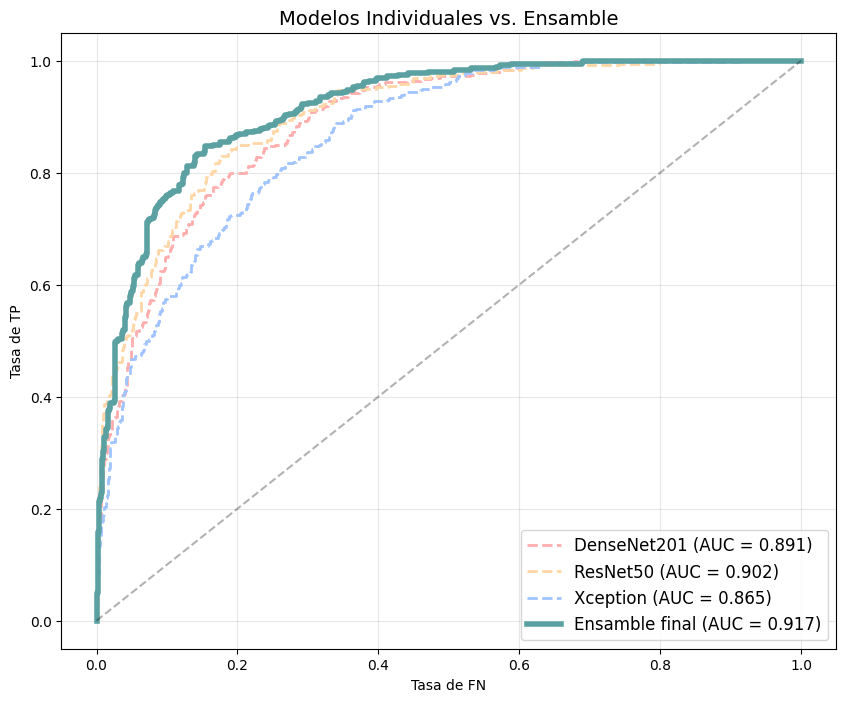

In [ ]:
#@title **Curvas ROC Superpuestas**

from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))

colores = ['#ffadad', '#ffd6a5', '#a0c4ff']
for i, (nombre, probs) in enumerate(preds_individuales.items()):
    auc_val = roc_auc_score(y_true, probs)
    fpr, tpr, _ = roc_curve(y_true, probs)
    plt.plot(fpr, tpr, label=f'{nombre} (AUC = {auc_val:.3f})', color=colores[i], linewidth=2, linestyle='--')

fpr_ens, tpr_ens, _ = roc_curve(y_true, preds_ensemble_simple)
auc_ens = roc_auc_score(y_true, preds_ensemble_simple)
plt.plot(fpr_ens, tpr_ens, label=f'Ensamble final (AUC = {auc_ens:.3f})', color='#5ca1a1', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)
plt.xlabel('Tasa de FN')
plt.ylabel('Tasa de TP')
plt.title('Modelos Individuales vs. Ensamble', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

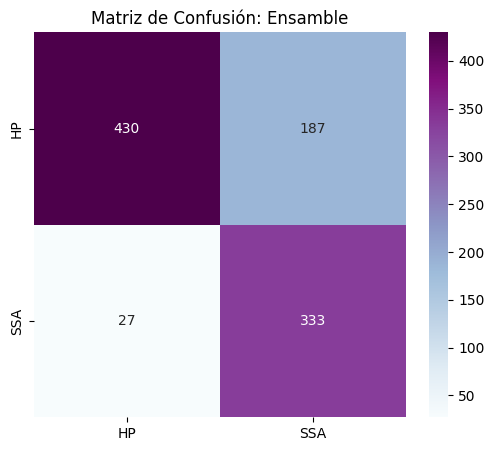


               precision    recall  f1-score   support

          HP       0.94      0.70      0.80       617
         SSA       0.64      0.93      0.76       360

    accuracy                           0.78       977
   macro avg       0.79      0.81      0.78       977
weighted avg       0.83      0.78      0.78       977



In [ ]:
#@title **Matriz de Confusión del Ensamble**
y_pred_clase = (preds_ensemble_simple > 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred_clase)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=['HP', 'SSA'], yticklabels=['HP', 'SSA'])
plt.title("Matriz de Confusión: Ensamble")
plt.show()

print("\n", classification_report(y_true, y_pred_clase, target_names=['HP', 'SSA']))

In [ ]:
#@title **Mejor umbral**

def probar_umbrales(y_true, probs_ensemble):
    print(f"{'Umbral':<10} {'Accuracy':<10} {'Recall (SSA)':<15} {'Precision':<10}")
    print("-" * 50)

    mejor_acc = 0
    mejor_umbral = 0.5

    for t in [0.5, 0.6, 0.7, 0.8, 0.85]:
        preds_t = (probs_ensemble > t).astype(int)

        acc = accuracy_score(y_true, preds_t)
        rec = recall_score(y_true, preds_t)
        prec = precision_score(y_true, preds_t)

        print(f"{t:<10} {acc:.4f}     {rec:.4f}          {prec:.4f}")

        if acc > mejor_acc:
            mejor_acc = acc
            mejor_umbral = t

    print("-" * 50)
    print(f"Mejor Accuracy ({mejor_acc:.4f}) se logra con umbral > {mejor_umbral}")

probar_umbrales(y_true, preds_ensemble_simple)

Umbral     Accuracy   Recall (SSA)    Precision 
--------------------------------------------------
0.5        0.7810     0.9250          0.6404
0.6        0.8188     0.8694          0.7065
0.7        0.8475     0.8000          0.7890
0.8        0.8280     0.6500          0.8478
0.85       0.8106     0.5583          0.8855
--------------------------------------------------
Mejor Accuracy (0.8475) se logra con umbral > 0.7


Umbral: 0.6 


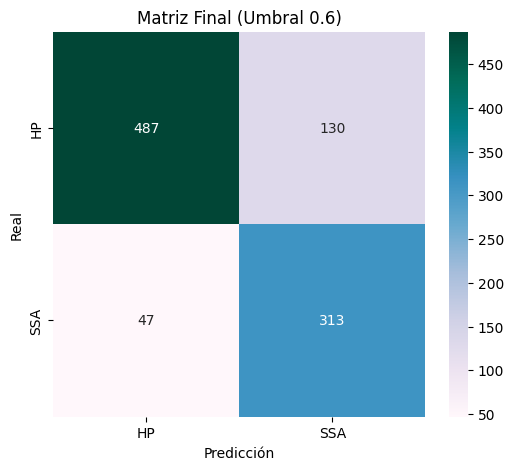


               precision    recall  f1-score   support

          HP       0.91      0.79      0.85       617
         SSA       0.71      0.87      0.78       360

    accuracy                           0.82       977
   macro avg       0.81      0.83      0.81       977
weighted avg       0.84      0.82      0.82       977



In [ ]:
#@title **Generar Matriz con umbral 6**

UMBRAL_OPTIMO = 0.6
print(f"Umbral: {UMBRAL_OPTIMO} ")

y_pred_optimo = (preds_ensemble_simple > UMBRAL_OPTIMO).astype(int)

cm = confusion_matrix(y_true, y_pred_optimo)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='PuBuGn',
            xticklabels=['HP', 'SSA'], yticklabels=['HP', 'SSA'])
plt.title(f"Matriz Final (Umbral {UMBRAL_OPTIMO})")
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()


print("\n", classification_report(y_true, y_pred_optimo, target_names=['HP', 'SSA']))

Umbral: 0.7 


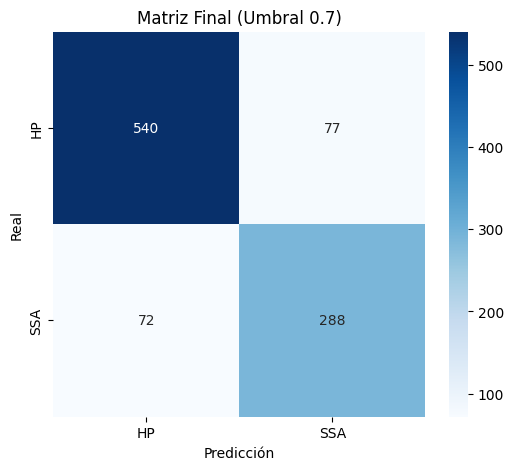


               precision    recall  f1-score   support

          HP       0.88      0.88      0.88       617
         SSA       0.79      0.80      0.79       360

    accuracy                           0.85       977
   macro avg       0.84      0.84      0.84       977
weighted avg       0.85      0.85      0.85       977



In [ ]:
#@title **Generar Matriz Optimizada y Reporte Final**

UMBRAL_OPTIMO = 0.7
print(f"Umbral: {UMBRAL_OPTIMO} ")

y_pred_optimo = (preds_ensemble_simple > UMBRAL_OPTIMO).astype(int)

cm = confusion_matrix(y_true, y_pred_optimo)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['HP', 'SSA'], yticklabels=['HP', 'SSA'])
plt.title(f"Matriz Final (Umbral {UMBRAL_OPTIMO})")
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()


print("\n", classification_report(y_true, y_pred_optimo, target_names=['HP', 'SSA']))

In [ ]:
#@title **Calcular Ensamble y Métricas**

def calcular_ensamble(preds_dict, pesos=None):

    if pesos is None:
        # Pesos iguales
        pesos = [1.0] * len(preds_dict)

    suma_preds = np.zeros_like(list(preds_dict.values())[0])
    suma_pesos = sum(pesos)

    i = 0
    for nombre, probs in preds_dict.items():
        weight = pesos[i]
        suma_preds += probs * weight
        i += 1

    ensemble_probs = suma_preds / suma_pesos
    return ensemble_probs

preds_ensemble_simple = calcular_ensamble(preds_individuales)

pesos_sin_xception = [0.5, 0.5, 0.0]
preds_ensemble_weighted = calcular_ensamble(preds_individuales, pesos=pesos_sin_xception)

print("Resultados del ensamble")
auc = roc_auc_score(y_true, preds_ensemble_simple)
print(f"AUC Ensemble Simple: {auc:.4f}")

auc_w = roc_auc_score(y_true, preds_ensemble_weighted)
print(f"AUC Ensemble Ponderado: {auc_w:.4f}")

Resultados del ensamble
AUC Ensemble Simple: 0.9167
AUC Ensemble Ponderado: 0.9162
